# Path Tracing Notebook
Implementation of Light Transport Algorithms

********************************************************************************************

In [1]:
import taichi as ti
ti.init(arch=ti.cpu, debug=True, random_seed=68739)

[Taichi] version 1.6.0, llvm 15.0.7, commit f1c6fbbd, osx, python 3.11.4
[Taichi] Starting on arch=arm64


[I 02/22/25 02:40:22.928 62364639] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from taichi.math import vec3, cross, normalize, dot

In [3]:
from primitives.primitives import Triangle, Sphere, Primitive
from base.frame import Frame, frame_from_z
from base.materials import Material
from base.bsdf import BSDF
from primitives.ray import Ray
from base.lights import DiffuseAreaLight, UniformLightSampler
from base.camera import PerspectiveCamera

In [4]:
cornell_box = "../scenes/cornell-box.pbrt"
volumetric_caustic = "../scenes/volumetric-caustic.pbrt"
door_scene = "../scenes/veach/veach-ajar.pbrt"
testball ="../scenes/material-testball/scene-v4.pbrt"
one = "../scenes/one.pbrt"
cb = "../scenes/cb.pbrt"
cb_spheres = "../scenes/cb-spheres.pbrt"
veach_mis = "../scenes/veach-mis/scene-v4.pbrt"


file_path = cornell_box

In [5]:
from primitives.primitives import Primitive

n_p = 1024
PS = ti.root.dense(ti.i, n_p)
primitives = Primitive.field()
PS.place(primitives)

<ti.SNode of type dense>

In [6]:
from pbrt.material_parser import parse_materials
from pbrt.shape_parser import extract_all_shapes, parse_shapes
from pbrt.parser import pbrt_to_dict

# Parse the scene
scene_dict = pbrt_to_dict(file_path)

# Extract the shapes
shapes_list = extract_all_shapes(file_path)

# Parse the materials
materials = scene_dict.get("MakeNamedMaterial", [])
parsed_materials = parse_materials(materials)

# Extract Primitives
n_primitives, light_count = parse_shapes(shapes_list, materials, primitives)

In [7]:
n_primitives, light_count

(36, 2)

In [8]:
from base.lights import DiffuseAreaLight

# Create a Taichi field for light sources
n_lights = light_count
LS = ti.root.dense(ti.i, n_lights)
lights = DiffuseAreaLight.field()
LS.place(lights)

<ti.SNode of type dense>

In [9]:
@ti.kernel
def populate_shapes():

    for i in range(n_primitives):

        primitives[i].bsdf.diffuse.type = 0
        primitives[i].bsdf.transmit.type = 1
        primitives[i].bsdf.dielectric.type = 2
        primitives[i].bsdf.conductor.type = 3
        primitives[i].bsdf.mirror.type = 4
        primitives[i].bsdf.specular.type = 5

        material = primitives[i].material

        if material.material_type==0:
            # Diffuse material
            primitives[i].bsdf.add_diffuse(material.reflectance)
        elif material.material_type==1:
            # Diffuse-Transmission material
            primitives[i].bsdf.add_transmission(material.reflectance, material.transmittance)
        elif material.material_type==2:
            # Dielectric material
            primitives[i].bsdf.add_dielectric(material.eta[0], material.reflectance, material.uroughness, material.vroughness)
        elif material.material_type==3:
            # Conductor material
            print(material.eta)
            primitives[i].bsdf.add_conductor(material.eta, material.k, material.uroughness, material.vroughness)

        if primitives[i].is_light == 1:
            print(i, primitives[i].material.emission)
            light_idx = primitives[i].light_idx
            lights[light_idx].shape_idx = i  # Link the light to the primitive
            lights[light_idx].two_sided = 0  # Assuming lights are one-sided
            lights[light_idx].Le = primitives[i].material.emission
            light_idx += 1

populate_shapes()

34 [17.000000, 12.000000, 4.000000]
35 [17.000000, 12.000000, 4.000000]


In [10]:
primitives[35].material

{'material_type': <taichi.lang.field.SNodeHostAccess object at 0x109dff310>, 'reflectance': [0.0, 0.0, 0.0], 'transmittance': [0.0, 0.0, 0.0], 'uroughness': <taichi.lang.field.SNodeHostAccess object at 0x10a346810>, 'vroughness': <taichi.lang.field.SNodeHostAccess object at 0x10a347a50>, 'eta': [1.0, 1.0, 1.0], 'k': [0.0, 0.0, 0.0], 'emission': [17.0, 12.0, 4.0]}

In [11]:
lights.to_numpy()

{'shape_idx': array([34, 35], dtype=int32),
 'Le': array([[17., 12.,  4.],
        [17., 12.,  4.]], dtype=float32),
 'two_sided': array([0, 0], dtype=int32)}

In [12]:
from primitives.aabb import AABB, BVHPrimitive

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
BS = ti.root.dense(ti.i, n_primitives)
bvh_primitives = BVHPrimitive.field()
BS.place(bvh_primitives)

scene_min = ti.Vector.field(3, dtype=ti.f32, shape=())  # Global min bounds
scene_max = ti.Vector.field(3, dtype=ti.f32, shape=())  # Global max bounds

@ti.kernel
def init_bounded_boxes():
    # Initialize scene bounding box with extreme values
    scene_min[None] = vec3(1e10, 1e10, 1e10)
    scene_max[None] = vec3(-1e10, -1e10, -1e10)

    for i in ti.ndrange(n_primitives):
        bvh_primitives[i].prim = primitives[i]
        bvh_primitives[i].prim_num = i

        # Get primitive bounds
        min_p, max_p = primitives[i].get_bounds()
        centroid = (min_p + max_p) * 0.5
        bvh_primitives[i].bounds = AABB(min_point=min_p, max_point=max_p, centroid=centroid)

        # Update scene-wide bounding box
        for j in range(3):  # Loop over x, y, z components
            scene_min[None][j] = min(scene_min[None][j], min_p[j])
            scene_max[None][j] = max(scene_max[None][j], max_p[j])


init_bounded_boxes()

bvh_primitives.shape[0], n_primitives

(36, 36)

In [13]:
OPS = ti.root.dense(ti.i, n_primitives)
ordered_prims = Primitive.field()
OPS.place(ordered_prims)

<ti.SNode of type dense>

In [14]:
from accelerators.bvh import BVHNode, BucketInfo

node_idx = 0

BVS = ti.root.dense(ti.i, 3 * n_primitives)
nodes = BVHNode.field()
BVS.place(nodes)


<ti.SNode of type dense>

In [15]:
nodes.shape[0]

108

In [16]:
total_nodes = ti.field(ti.i32, shape=())
split_method = ti.field(ti.i32, shape=())
start = ti.field(ti.i32, shape=())
end = ti.field(ti.i32, shape=())
ordered_prims_idx = ti.field(ti.i32, shape=())
stack_ptr = ti.field(ti.i32, shape=())
# ordered_prims_size = ti.field(ti.i32, shape=())

@ti.kernel
def init_stack():
    total_nodes[None] = 0
    split_method[None] = 0
    start[None] = 0
    end[None] = n_primitives
    ordered_prims_idx[None] = 0
    stack_ptr[None] = 0
    # ordered_prims_size[None] = 0

init_stack()

In [17]:
stack = ti.field(ti.i32, shape=(3*n_primitives, 4))
n_buckets = 12
buckets = BucketInfo.field(shape=(n_buckets))
costs = ti.field(dtype=ti.f32, shape=(n_buckets-1))

In [18]:
from accelerators.bvh import build_bvh

start_t = time.time()

build_bvh(primitives, bvh_primitives, start, end, ordered_prims, nodes, total_nodes, split_method, stack, stack_ptr, ordered_prims_idx, costs, buckets)

end_t = time.time()

In [19]:
# total_nodes = ti.field(ti.i32, shape=())
# split_method = ti.field(ti.i32, shape=())
# start = ti.field(ti.i32, shape=())
# end = ti.field(ti.i32, shape=())
# ordered_prims_idx = ti.field(ti.i32, shape=())
# stack_ptr = ti.field(ti.i32, shape=())
# max_prims_in_node = ti.field(ti.i32, shape=())
# # ordered_prims_size = ti.field(ti.i32, shape=())
#
# @ti.kernel
# def init_stack():
#     total_nodes[None] = 0
#     split_method[None] = 0
#     start[None] = 0
#     end[None] = n_primitives
#     ordered_prims_idx[None] = 0
#     stack_ptr[None] = 0
#     max_prims_in_node[None] = 4
#
# init_stack()

In [20]:
# stack = ti.field(ti.i32, shape=(3*n_primitives, 4))
# n_buckets = 12
# buckets = BucketInfo.field(shape=(n_buckets))
# costs = ti.field(dtype=ti.f32, shape=(n_buckets-1))

In [21]:
# from accelerators.hlbvh import build_hlbvh
# from accelerators.bvh import build_bvh
#
# start_t = time.time()
#
# root = ti.field(ti.i32, shape=())
#
# build_hlbvh(
#     primitives,
#     bvh_primitives,
#     ordered_prims,
#     n_primitives,       # number of actual primitives
#     nodes,
#     total_nodes,
#     ordered_prims_idx,  # you already have this
#     max_prims_in_node,
#     root
# )
#
# end_t = time.time()

In [22]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))
print(f"Total Nodes: {total_nodes}")

Elapsed (with compilation) = 0.26944899559020996
Total Nodes: 57


In [23]:
from tests.test_bvh import print_bvh

print_bvh(nodes, total_nodes[None])

BVHNode 0 [Interior]: split_axis = 1 child_0 = 1 child_1 = 30 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 1 [Interior]: split_axis = 1 child_0 = 2 child_1 = 13 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 2 [Interior]: split_axis = 1 child_0 = 3 child_1 = 6 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 3 [Interior]: split_axis = 1 child_0 = 4 child_1 = 5 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 4 [Leaf]: first_prim_offset = 0 n_primitives = 2 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, -1.000000, 7.800000] )
BVHNode 5 [Leaf]: first_prim_offset = 2 n_primitives = 2 bounds = (min: [-1.000000, 1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 6 [Interior]: split_axis = 0 child_0 = 7 child_1 = 8 bounds = (min: [-1.000000, -1.000000, 5.800000] , m

In [24]:
from tests.test_bvh import test_bvh
max_nodes = n_primitives
debug_stack = ti.field(dtype=ti.i32, shape=(max_nodes,))
debug_ptr = ti.field(dtype=ti.i32, shape=(1,))
error_count = ti.field(dtype=ti.i32, shape=(1,))

test_bvh(nodes, debug_stack, debug_ptr, error_count)

BVH test error count = 0


In [25]:
from accelerators.bvh import LinearBVHNode
from accelerators.bvh import flatten_bvh

# create a linear representation of the bvh tree (empty)

LBVS = ti.root.dense(ti.i, total_nodes[None])
linear_bvh = LinearBVHNode.field()
LBVS.place(linear_bvh)

stack_size = 2 * n_primitives - 1  # Maximum possible stack size
stack3 = ti.Vector.field(3, dtype=ti.i32, shape=stack_size)
stack_top_2 = ti.field(dtype=ti.i32, shape=())

start_t = time.time()
total_nodes = flatten_bvh(nodes, linear_bvh, 0, stack3, stack_top_2)
end_t = time.time()
print(f"Total flattened nodes: {total_nodes}")

Total flattened nodes: 57


In [26]:
linear_bvh[0].second_child_offset

30

In [27]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.05796027183532715


In [28]:
from tests.test_linear_bvh import print_flattened_bvh

print_flattened_bvh(linear_bvh, total_nodes)

LinearBVHNode 0 [Interior]: axis = 1 second_child_offset = 30 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 1 [Interior]: axis = 1 second_child_offset = 13 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 2 [Interior]: axis = 1 second_child_offset = 6 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 3 [Interior]: axis = 1 second_child_offset = 5 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 4 [Leaf]: primitives_offset = 0 n_primitives = 2 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, -1.000000, 7.800000] )
LinearBVHNode 5 [Leaf]: primitives_offset = 2 n_primitives = 2 bounds = (min: [-1.000000, 1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 6 [Interior]: axis = 0 second_child_offset = 8 bounds = (min: [-1.000000, -1.000000, 5

In [29]:
from tests.test_linear_bvh import test_flattened_bvh

max_nodes = n_primitives
debug_stack = ti.field(dtype=ti.i32, shape=(max_nodes,))
debug_ptr = ti.field(dtype=ti.i32, shape=(1,))
error_count = ti.field(dtype=ti.i32, shape=(1,))

test_flattened_bvh(linear_bvh, debug_stack, debug_ptr, error_count)

Flattened BVH test error count = 0


In [30]:
# Parse Camera Data

camera_data = scene_dict["Camera"][0]["properties"]
camera_data

{'fov': [19.5]}

In [31]:
scene_min[None], scene_max[None]

([-1.         -1.00000012  5.80000019], [1.         1.         7.80000019])

In [32]:
from taichi.lang.matrix_ops import norm
import taichi as ti
from taichi.math import (
    vec3, length, normalize, cross, radians, sin, tan, dot
)
from base.frame import create_frame
from base.camera import PerspectiveCamera

@ti.func
def frame_look_at(eye, center, up):
    """
    PBRT v4-like LookAt:
      - +Z = forward = (center - eye)
      - +X = right = cross(up, forward)
      - +Y = up = cross(forward, right)
    """
    forward_raw = center - eye
    if length(forward_raw) < 1e-8:
        forward_raw = vec3(0, 0, 1)
    forward = normalize(forward_raw)

    up_len = length(up)
    if up_len < 1e-8:
        up = vec3(0, 1, 0)
        up_len = 1.0
    up_n = up / up_len

    # If up is nearly parallel to forward, choose a fallback.
    dot_uf = ti.abs(dot(up_n, forward))
    if dot_uf > 0.9999:
        fallback = vec3(0, 1, 0)
        if ti.abs(dot(fallback, forward)) > 0.9999:
            fallback = vec3(1, 0, 0)
        up_n = normalize(fallback)

    # PBRT style: z = forward, x = cross(up, z), y = cross(z, x)
    z = forward
    x_raw = vec3(1, 0, 0) if ti.abs(length(cross(up_n, z))) < 1e-8 else normalize(cross(up_n, z))
    y = cross(z, x_raw)
    return create_frame(x_raw, y, z)

@ti.kernel
def auto_fit_camera(scene_min: vec3, scene_max: vec3, fov_degrees: ti.f32, film_width: ti.i32, film_height: ti.i32, margin:ti.f32) -> PerspectiveCamera:
    """
    Compute an auto-fit camera based on the scene bounding box.

    Parameters:
      scene_min, scene_max: numpy arrays (or taichi vectors) representing the bounding box.
      fov_degrees: the vertical field-of-view in degrees.
      film_width, film_height: resolution of the film.
      margin: a multiplier to leave extra room around the scene.

    Returns:
      A PerspectiveCamera with the computed position and framing.
    """
    # Compute center of bounding box.
    center = 0.5 * (scene_min + scene_max)
    diag = scene_max - scene_min
    # Use the norm of the diagonal to compute a bounding sphere radius.
    r = 0.5 * norm(diag)
    if r < 1e-8:
        r = 1.0

    # Compute half fov in radians.
    half_fov = radians(0.5 * fov_degrees)
    # Compute distance required so that the sphere fits in the view.
    # (r / sin(half_fov)) gives the distance required for a sphere to fill the screen.
    distance = margin * (r / sin(half_fov))

    # Alternative for perfect fit
    # local_rad = 0.5 * ti.max(diag.x, ti.max(diag.y, diag.z))
    # distance = local_rad / tan(0.5 * radians(fov_degrees)) + local_rad

    # Place camera along the negative z-axis relative to center.
    eye = center - distance * vec3([0, 0, 1])

    # In this example we assume world up is (0,1,0).
    world_up = vec3(0, 1, 0)
    # Depending on your coordinate conventions you might need to flip world_up.
    cam_frame = frame_look_at(vec3(*eye), vec3(*center), world_up)

    # Film plane size in camera space at z=1.
    aspect = film_width / film_height
    screen_height = 2.0 * tan(half_fov)
    screen_width  = aspect * screen_height

    # Differentials in camera space.
    dx_c = vec3(screen_width / film_width, 0.0, 0.0)
    dy_c = vec3(0.0, screen_height / film_height, 0.0)

    cam = PerspectiveCamera(
        width         = film_width,
        height        = film_height,
        position      = vec3(*eye),
        frame         = cam_frame,
        fov           = fov_degrees,
        aspect_ratio  = aspect,
        lens_radius   = 0.0,
        focal_distance= 1e3,
        screen_dx     = screen_width,
        screen_dy     = screen_height,
        dx_camera     = dx_c,
        dy_camera     = dy_c
    )
    return cam

# Example usage:
# scene_min[None] = [...]
# scene_max[None] = [...]
fov = float(camera_data.get('fov', 45.0)[0])
camera = auto_fit_camera(scene_min[None], scene_max[None], fov, 100, 100, 0.7)


In [33]:
# import taichi as ti
# from taichi.math import vec3, normalize, cross, radians, tan
# from base.camera import PerspectiveCamera
# from base.frame import Frame  # your Frame class
#
# width = 400
# height = 400
#
# # Global camera field
# camera = PerspectiveCamera.field(shape=())
#
# @ti.kernel
# def initialize_camera():
#     obj_min = scene_min[None]
#     obj_max = scene_max[None]
#     center  = 0.5 * (obj_min + obj_max)
#     extent  = obj_max - obj_min
#     local_rad = 0.5 * ti.max(extent.x, ti.max(extent.y, extent.z))
#
#     print(obj_min, obj_max, center)
#
#     fov_degrees = 60.0 #float(camera_data.get('fov', 45.0))
#     fov_rad = radians(fov_degrees)
#
#     d = local_rad / tan(0.5 * fov_rad) + local_rad
#     pos = center - vec3(0.0, 1.0, d)
#
#     forward = normalize(center - pos)
#
#     camera[None].width = width
#     camera[None].height = height
#     camera[None].position = pos - vec3([0, 0, 2.5])
#
#     camera[None].frame = frame_from_z(forward)
#
#     camera[None].fov = fov_degrees
#     aspect_ratio = width / float(height)
#     camera[None].aspect_ratio = aspect_ratio
#     camera[None].lens_radius = float(camera_data.get('lensradius', 0.0))
#     camera[None].focal_distance = d
#
#     screen_dy = 2.0 * tan(0.5 * fov_rad)
#     screen_dx = screen_dy * aspect_ratio
#     camera[None].screen_dx = screen_dx
#     camera[None].screen_dy = screen_dy
#     camera[None].dx_camera = vec3([screen_dx / width, 0.0, 0.0])
#     camera[None].dy_camera = vec3([0.0, screen_dy / height, 0.0])
#
#
# initialize_camera()


In [34]:
camera

{'width': 100, 'height': 100, 'position': [0.0, -5.960464477539063e-08, -0.35936784744262695], 'frame': {'x': [1.0, 0.0, -0.0], 'y': [-0.0, 1.0, 0.0], 'z': [0.0, 0.0, 1.0]}, 'fov': 19.5, 'aspect_ratio': 1.0, 'lens_radius': 0.0, 'focal_distance': 1000.0, 'screen_dx': 0.3436628580093384, 'screen_dy': 0.3436628580093384, 'dx_camera': [0.003436628496274352, 0.0, 0.0], 'dy_camera': [0.0, 0.003436628496274352, 0.0]}

In [35]:
scene_min[None], scene_max[None]

([-1.         -1.00000012  5.80000019], [1.         1.         7.80000019])

In [36]:
camera.frame

{'x': [1.0, 0.0, -0.0], 'y': [-0.0, 1.0, 0.0], 'z': [0.0, 0.0, 1.0]}

In [37]:
@ti.kernel
def test_camera():
    # Generate a ray
    s, t = 0.5, 0.5  # Center of the screen
    ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir = camera.generate_ray_differential(s, t)
    print(ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir)

test_camera()

[0.000000, -0.000000, -0.359368] [0.000000, 0.000000, 1.000000] [0.000000, -0.000000, -0.359368] [0.003437, 0.000000, 0.999994] [0.000000, -0.000000, -0.359368] [0.000000, 0.003437, 0.999994]


In [38]:
from base.scene import Scene

pt = 0
mis = 1

# Instantiate a Scene object with the Camera object
scene = Scene(integrator=pt, spp=64, max_depth=6, sample_lights=1, sample_bsdf=1)

In [39]:
from base.render import render

# Initialize the image field outside the kernel using the actual values
image = ti.Vector.field(3, dtype=ti.f32, shape=(camera.width, camera.height))


start_t = time.time()

# Call the render_scene kernel
render(scene, image, lights, camera, ordered_prims, linear_bvh)

end_t = time.time()

print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 16.46369194984436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


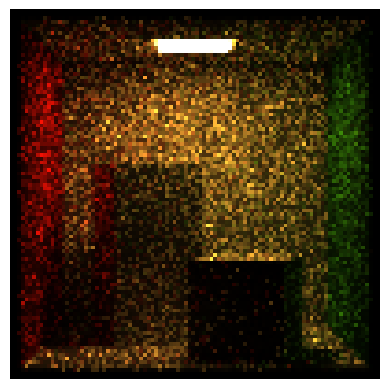

In [40]:
image_np = image.to_numpy()
# if np.isnan(image_np).any() or np.isinf(image_np).any():
#     print("Warning: NaN or Inf values detected in the image")
# image_np = np.clip(image_np, 0, 1)  # Clip values between 0 and 1
plt.imshow(image_np)
plt.axis('off')
plt.show()

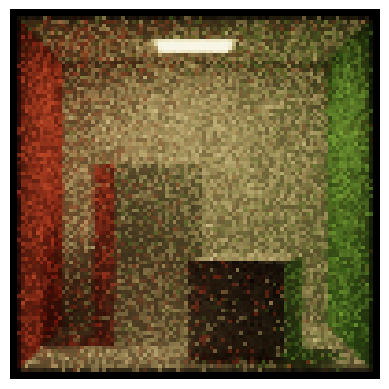

In [41]:
def tone_mapping(hdr_image, gamma=2.2):
    ldr_image = hdr_image / (1.0 + hdr_image)
    ldr_image = np.power(ldr_image, 1.0 / gamma)
    return np.clip(ldr_image, 0, 1)

ldr_image = tone_mapping(image_np)

# Display the tone-mapped image
plt.imshow(ldr_image)
plt.axis('off')
plt.show()

In [42]:
r

NameError: name 'r' is not defined